In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
import dask.array as da



la simulation chargée est: dahu_620
depuis: dahu
KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 37508)> Size: 150kB
array([0.  , 0.05, 0.1 , ..., 0.  , 0.  , 0.  ], dtype=float32), 'y': <xarray.IndexVariable 'y' (y: 2048)> Size: 8kB
array([0.000000e+00, 2.454369e-01, 4.908738e-01, ..., 5.019185e+02,
       5.021639e+02, 5.024094e+02], dtype=float32), 'x': <xarray.IndexVariable 'x' (x: 2048)> Size: 8kB
array([0.000000e+00, 2.454369e-01, 4.908738e-01, ..., 5.019185e+02,
       5.021639e+02, 5.024094e+02], dtype=float32), 'level': <xarray.IndexVariable 'level' (level: 1)> Size: 4B
array([0.], dtype=float32), 'psi': <xarray.Variable (time: 37508, level: 1, y: 2048, x: 2048)> Size: 629GB
dask.array<open_dataset-psi, shape=(37508, 1, 2048, 2048), dtype=float32, chunksize=(10, 1, 2048, 2048), chunktype=numpy.ndarray>, 'q': <xarray.Variable (time: 37508, level: 1, y: 2048, x: 2048)> Size: 629GB
dask.array<open_dataset-q, shape=(37508, 1, 2048, 2048), dtype=float32, chunksize=(10,

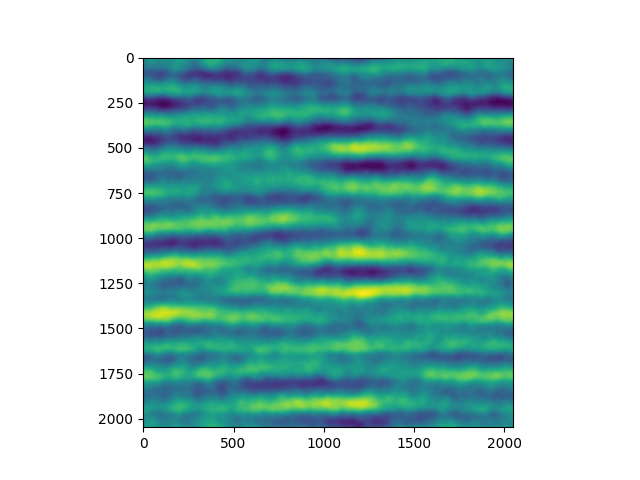

In [21]:


# Number of simulation
n = 620

# Choose between 'local' or 'dahu'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'
else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0], chunks={'time': 10})

print(dataset.variables.keys())

# Load variables in chunks
t = dataset['time'].isel(time=slice(0, 400)).data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel(time=slice(0, 400), level=0).data
q = dataset['q'].isel(time=slice(0, 400), level=0).data

# Lecture des paramètres :
param = io.read_params(Path)
print(param)
f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
nx = int(param['NX'])
ny = int(param['NY'])
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

plt.figure()
plt.imshow(psi[-2, :, :])
print(np.shape(t))


In [11]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [12]:
#Computing k_rhines to have an idea of the modes to choose

epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)

print('k_rhines =',k_rhines)    

n=Lx*k_rhines/(2*np.pi)
print("n",n)

k_rhines = 0.25
n 19.999999999826247


(400,)


TypeError: Invalid shape (400, 2048, 2048) for image data

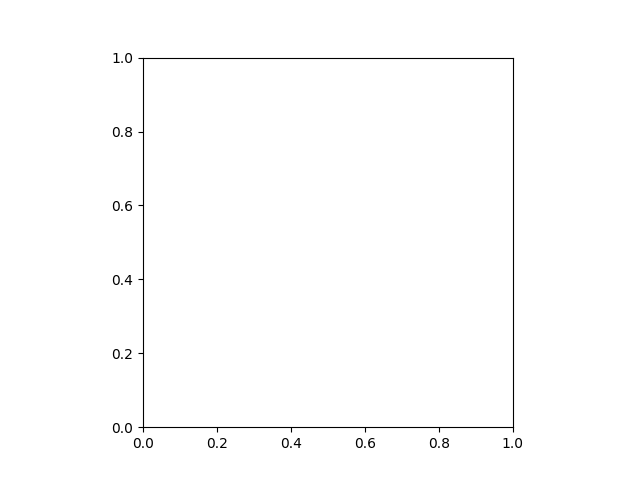

In [38]:
m_sel=10
n_sel=10

time_sel=np.arange(0,len(t),1,dtype=int)


psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 0)
print(np.shape(psi_mn))
# Visualize the original field
plt.figure()
plt.imshow(psi[time_sel, :, :])
plt.colorbar()
plt.title(f'Original field at time {time_sel}')
plt.show()

# Construct and visualize the mode
N = np.shape(psi[1, :, :])[-1]
x = np.linspace(0, Lx, N)
y = np.linspace(0, Lx, N)
X, Y = np.meshgrid(x, y)

mode = np.exp(-1j*np.pi*np.sqrt(m_sel**2 + n_sel**2)*X/Lx) * np.sin(m_sel*np.pi*X/Lx) * np.sin(n_sel*np.pi*Y/Lx)

plt.figure()
plt.imshow(np.real(mode))
plt.colorbar()
plt.title(f'Mode ({m_sel}, {n_sel})')
plt.show()

# Reconstruct and visualize the projected field
reconstructed_field = np.real(psi_mn[1] * mode)

plt.figure()
plt.imshow(reconstructed_field)
plt.colorbar()
plt.title(f'Projection of psi on mode ({m_sel}, {n_sel})')
plt.show()


In [36]:
# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

IndexError: Too many indices for array